In [1]:
# import sys
# sys.path.append('..')

In [2]:
from utility import load_dataset, load_model_with_ckpt, make_segments_and_graph
import draw_utils

/opt/miniconda3/envs/yrchen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torchvision.transforms as VT
from torchvision.datasets import FashionMNIST

ori_dataset = FashionMNIST('~/data', train=False, transform=VT.ToTensor())
dataset = load_dataset('fashion_mnist', train=False)

----- Loading test dataset -----


In [4]:
hidden_dim = 64
ckpt_name = '/home/dragonchen/mlruns/0/1bd315b212174293b383230d7bd8afc5/artifacts/best.pt'

aggr = 'add'
pool = 'max'

device = torch.device('cuda:1')
model = load_model_with_ckpt(
    input_dim=dataset.num_features,
    hidden_dim=hidden_dim,
    output_dim=dataset.num_classes,
    drn_k=4, aggr=aggr, pool=pool,
    device=device,
    ckpt_name=ckpt_name,
)

Pooling with max
Using self-loops
There are 2 aggregation layers


In [5]:
evaluate_on_testset = False

if evaluate_on_testset:
    import sys
    sys.path.append('..')
    from models.graph_phase import test
    from torch_geometric.loader import DataLoader

    test_dev = torch.device('cpu')
    loader = DataLoader(dataset, batch_size=128, shuffle=False)
    acc, _ = test(model.to(test_dev), loader, device=test_dev, mlflow_log=False)
    print(f'DRN got {acc * 100:.2f}% acc on testing set.')
    model = model.to(device)

In [6]:
rc = VT.RandomCrop(32, padding=2)

img_idx = 11
img_ori, lbl = ori_dataset[img_idx]
img_ori = rc(img_ori)
compactness = 0.01
img_sp, segments, node2map = make_segments_and_graph(
    torch.permute(img_ori, (1, 2, 0)), channel_axis=None,
    compactness=compactness,
)
img_sp.y = torch.tensor(lbl)

# img_sp = dataset[img_idx]

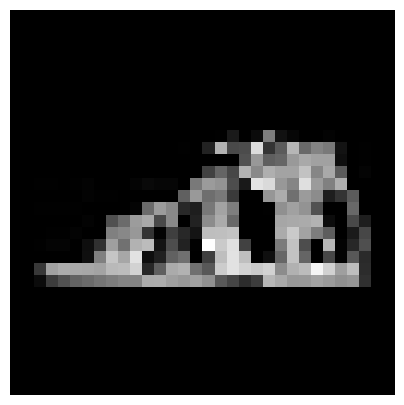

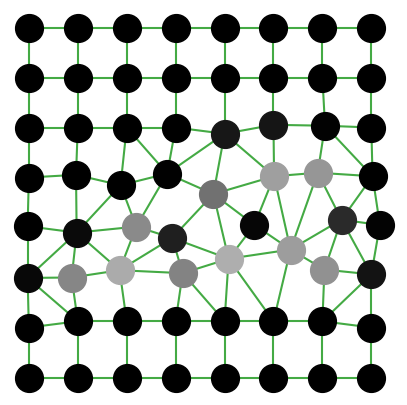

In [7]:
import matplotlib.pyplot as plt

# original
draw_utils.show_original(img_ori)

# superpixel version
draw_utils.draw_superpixel_from_graph(
    img_sp.pos, img_sp.x[:, 2].unsqueeze(dim=1),
    img_sp.edge_index,
)
plt.show()

In [8]:
img_sp.batch = torch.zeros(img_sp.x.shape[0]).long()
img_sp = img_sp.to(device)

out = model(img_sp).detach().cpu()

print('true', lbl)
print('pred', out.argmax(1).item())

true 5
pred 5


In [9]:
# torch.manual_seed(1340)
for i, c in enumerate(torch.softmax(out, 1).tolist()[0]):
    print(f'{i} {c:.04f}')

0 0.0000
1 0.0000
2 0.0000
3 0.0000
4 0.0000
5 1.0000
6 0.0000
7 0.0000
8 0.0000
9 0.0000


In [10]:
lbl_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [11]:
use_cuda = True

In [12]:
from torchinfo import summary
from torchvision import models
import sys
sys.path.append('..')
from models import lenet, resnet

if use_cuda:
    device2 = torch.device('cuda:1')
else:
    device2 = torch.device('cpu')

# cnn model
model_name = 'resnet18'

def load_state_dict(model, ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device2)
    model.load_state_dict(ckpt)

if model_name == 'lenet':
    cnn_model = lenet.LeNet(1)
    ckpt_name = 'lenet_e50_traint8742_test8725.pt'
elif model_name == 'resnet18':
    cnn_model = resnet.resnet18(1)
    ckpt_name = 'resnet18_e50_test9317.pt'
# elif model_name == 'resnet':
#     cnn_model = resnet.resnet50()
#     ckpt_name = 'resnet_hs_e60_test9912.pt'

ckpt_folder = '../ckpts/cnnckpt_fashion_mnist/'
load_state_dict(cnn_model, ckpt_folder + ckpt_name)

cnn_model = cnn_model.to(device2)
cnn_model.eval()
summary(cnn_model, input_size=(1, 1, 32, 32), depth=2, device=device2)

Layer (type:depth-idx)                   Output Shape              Param #
ResNetOriginal                           [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           576
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-4                   [1, 64, 32, 32]           73,984
│    └─BasicBlock: 2-5                   [1, 64, 32, 32]           73,984
├─Sequential: 1-3                        [1, 128, 16, 16]          --
│    └─BasicBlock: 2-6                   [1, 128, 16, 16]          230,144
│    └─BasicBlock: 2-7                   [1, 128, 16, 16]          295,424
├─Sequential: 1-4                        [1, 256, 8, 8]            --
│    └─BasicBlock: 2-8                   [1, 256, 8, 8]          

In [13]:
cnn_model

ResNetOriginal(
  (pre): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
    

In [14]:
rc = VT.RandomCrop(32, padding=2)
img_temp = rc(img_ori)

out = cnn_model(img_temp.to(device2).unsqueeze(dim=0))
print('label', lbl)
print('CNN predict', out.argmax(dim=1).detach().item())

label 5
CNN predict 5


## Start Explaining

In [15]:
from models.jit_drn_model import (
    knn_graph, to_undirected, normalized_cut_2d,
    graclus_cluster,
    global_pool_aggr,
)
import numpy as np
from torch_scatter import scatter
from torch_geometric.typing import OptTensor, Optional, Tuple
from torch import Tensor
from torch_geometric.nn.pool.consecutive import consecutive_cluster
from torch_geometric.nn.pool.pool import pool_batch
import torch

verbose = False

# def consecutive_cluster(src):
#     unique, inv = torch.unique(src, sorted=True, return_inverse=True)
#     perm = torch.arange(inv.size(0), dtype=inv.dtype, device=inv.device)
#     perm = inv.new_empty(unique.size(0)).scatter_(0, inv, perm)
#     return inv, perm

def _aggr_pool_x(cluster, x, aggr: str, size: Optional[int] = None):
    """Call into scatter with configurable reduction op"""
    return scatter(x, cluster, dim=0, dim_size=size, reduce=aggr)

def global_pool_aggr(x, batch: OptTensor, aggr: str, size: Optional[int] = None):
    """Global pool via passed aggregator: 'mean', 'add', 'max'"""
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if batch is not None:
        size = int(batch.max().item() + 1)
    assert batch is not None
    return scatter(x, batch, dim=0, dim_size=size, reduce=aggr)

# this function is specialized compared to the more general non-jittable version
# in particular edge_attr can be removed since it is always None
def aggr_pool(cluster, x, batch: OptTensor, aggr: str) -> Tuple[Tensor, OptTensor]:
    """jit-friendly version of max/mean/add pool"""
#     print('c1', cluster.shape)
#     print(cluster[:20])
    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)
    
    cluster_data = {
        'c1': c1,
        'c2': cluster.detach().cpu(),
        'p': perm.detach().cpu(),
    }

    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)
    return x, batch, cluster_data

def aggr_pool_x(cluster, x, batch: OptTensor, aggr: str, size: Optional[int] = None) -> Tuple[Tensor, OptTensor]:
    """*_pool_x with configurable aggr method"""
    global node_hist
    if batch is None and size is None:
        raise Exception('Must provide at least one of "batch" or "size"')
    if size is not None and batch is not None:
        batch_size = int(batch.max().item()) + 1
        return _aggr_pool_x(cluster, x, aggr, batch_size * size), None

    c1 = cluster.detach().cpu()
    cluster, perm = consecutive_cluster(cluster)

    cluster_data = {
        'c1': c1,
        'c2': cluster.detach().cpu(),
        'p': perm.detach().cpu(),
    }
    
    x = _aggr_pool_x(cluster, x, aggr)
    if batch is not None:
        batch = pool_batch(perm, batch)

    return x, batch, cluster_data

In [16]:
def get_explanation(model, data):
    node_hist = []
    
    drn = model.drn
    x = data.x
    batch = data.batch
    
    x = drn.datanorm * x
    x = drn.inputnet(x)

    nAgg = len(drn.agg_layers)

    node_hist.append({'x': x.detach().cpu()})
    for i, edgeconv in enumerate(drn.agg_layers):
        knn = knn_graph(x, drn.k, batch, loop=drn.loop, flow=edgeconv.flow)
        edge_index = to_undirected(knn)
        x = edgeconv(x, edge_index)
        
        weight = normalized_cut_2d(edge_index, x)
        cluster = graclus_cluster(edge_index[0], edge_index[1], weight, x.size(0))

        if i == nAgg - 1:
            x, batch, cluster_data = aggr_pool_x(cluster, x, batch, drn.aggr_type)
        else:
            x, batch, cluster_data = aggr_pool(cluster, x, batch, drn.aggr_type)

        node_hist.append(cluster_data)
            
        xx = data.x.cpu()
        ee = edge_index.cpu()
        node_hist.append({'x': x.detach().cpu()})

    x = global_pool_aggr(x, batch, drn.aggr_type)
    node_hist.append({'global_x': x.detach().cpu()})
    
    return node_hist

from collections import defaultdict
def parse_node_l1(
    node_hist,
    gx_threshold=1, counter_threshold=1,
    verbose=False,
    smooth=False, smooth_thresholds=None,
):
    counter = defaultdict(int)
    gx = node_hist[-1]['global_x']
    for i, g in enumerate(gx.tolist()[0]):
        if g > gx_threshold:
            xx2 = node_hist[-2]['x']
            xx2k = xx2[:, i].tolist().index(g)
            counter[xx2k] += 1
            
#     print(node_hist[1:-1:2])
    
    # setting
    l1 = node_hist[1]
    l2 = node_hist[3]

    # set the threshold
    nodes_global = [n for n in counter if counter[n] >= counter_threshold]
    if smooth:
        cosine = torch.nn.CosineSimilarity(dim=0)
        x_l1 = node_hist[0]['x']
        x_l2 = node_hist[2]['x']

    # layer2
    cosine_hist = [[], []]
    nodes_l2 = []
    for n in nodes_global:
        idx = l2['p'][n].item() # put node-num get cluster idx
        c = l2['c2'][idx].item() # extract original node-num from cluster idx
        nodes = torch.arange(len(l2['c2']))[l2['c2'] == c].tolist()
        if smooth:
#             print('idx', idx, c)
            anchor = x_l2[idx]
#             print('l2', [cosine(anchor, x_l2[n]) for n in nodes])
            ch_l2 = [cosine(anchor, x_l2[n]).item() for n in nodes if n != idx]
            cosine_hist[0] += ch_l2
#             nodes = [n for n in nodes if cosine(anchor, x_l2[n]) >= smooth_thresholds[0]]

        nodes_l2 += nodes

    # layer1
    nodes_l1 = []
    for n in nodes_l2:
        idx = l1['p'][n].item() # put node-num get cluster idx
        c = l1['c2'][idx].item() # extract original node-num from cluster idx
        nodes = torch.arange(len(l1['c2']))[l1['c2'] == c].tolist()
        if smooth:
#             print('idx', idx, c)
            anchor = x_l1[idx]
#             print('l1', [cosine(anchor, x_l1[n]) for n in nodes])
            ch_l1 = [cosine(anchor, x_l1[n]).item() for n in nodes if n != idx]
            cosine_hist[1] += ch_l1
#             nodes = [n for n in nodes if cosine(anchor, x_l1[n]) >= smooth_thresholds[1]]

        nodes_l1 += nodes

    return nodes_l1, cosine_hist

In [17]:
def mask_with_spgie(img_ori, img_g, segments, lbl,
                    alpha=0.3,
                    gx_threshold=1, counter_threshold=1,
                    return_nodes=False,
                    smooth=False,
                    smooth_thresholds=None,
):
    num_nodes = np.max(segments) + 1
    node2map = {n: (segments == n) for n in range(num_nodes)}
    
    torch.manual_seed(1340)
    img_g.batch = torch.zeros(img_g.x.shape[0]).long()
    img_g = img_g.to(device)
    out = model(img_g).detach().cpu()
    
    node_hist = get_explanation(model, img_g)
    final_nodes, cosine_hist = parse_node_l1(
        node_hist,
        gx_threshold=gx_threshold, counter_threshold=counter_threshold,
        smooth=smooth, smooth_thresholds=smooth_thresholds,
    )
    
    # pixels version
    img_ori_temp = img_ori.numpy().copy()
    img_ori_temp = np.repeat(img_ori_temp, 3, axis=0)
    img_temp = img_ori_temp.copy() * alpha
    img_masked = img_temp.copy()

    for n in final_nodes:
        if n in node2map:
            m = node2map[n]
            img_masked[:, m] += img_ori_temp[:, m] * (1 - alpha)
            img_temp[0, m] += (1 - alpha)
        else:
            print('error in', n)
    if return_nodes:
        return img_masked, final_nodes, cosine_hist

#     draw_utils.show_original(img_masked)
#     draw_utils.show_original(img_temp)

    return img_masked


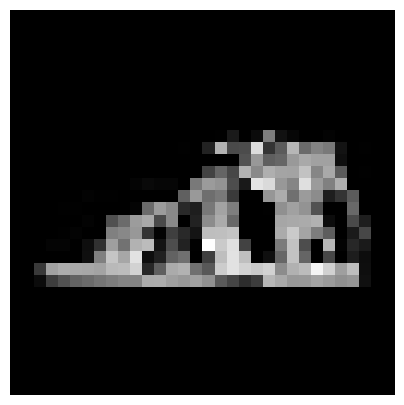

In [18]:
temp = mask_with_spgie(
    img_ori, img_sp, segments, lbl,
    alpha=0.33,
)
draw_utils.show_original(temp)

In [25]:
cnn_model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (act): ReLU(inplace=True)
)

In [19]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2

def mask_with_cam(img_ori, lbl, alpha=0.3):
    if 'resnet' in model_name:
        target_layers = [cnn_model.layer4[-1]]
    else:
        target_layers = [cnn_model.conv2]

    input_tensor = img_ori.unsqueeze(0).to(device2)
    cam = GradCAM(model=cnn_model, target_layers=target_layers, use_cuda=use_cuda)
    target_category = lbl

    targets = [ClassifierOutputTarget(lbl)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    img = np.transpose(img_ori, (1, 2, 0))
    mask = grayscale_cam
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    h = heatmap.mean(axis=2)
    img_cam = h * img_ori.numpy()
#     plt.imshow(np.transpose(img_cam, (1, 2, 0)))
#     plt.show()
    return img_cam

# mask_with_cam(img_ori, lbl)

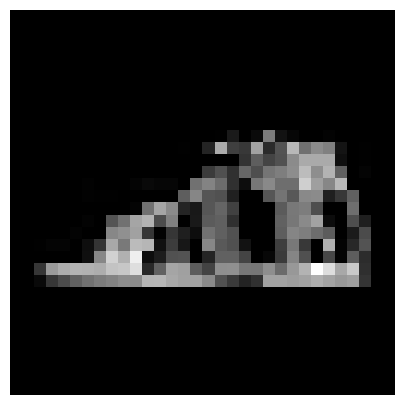

In [21]:
temp = mask_with_cam(img_ori, lbl)
draw_utils.show_original(temp)

In [22]:
# LIME CNN
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries


lime_cnn_explainer = lime_image.LimeImageExplainer()
segmenter = SegmentationAlgorithm('slic',
     n_segments=75,
     multichannel=False,
     slic_zero=True, start_label=0
)

@torch.no_grad()
def batch_predict(img):
    global cnn_model
    img = np.transpose(img, (0, 3, 1, 2))
    img = torch.from_numpy(img).float().contiguous()
    img = img[:, :1, :, :]

    cnn_model = cnn_model.to(device2)
    output = cnn_model(img.to(device2))
    output = torch.nn.functional.softmax(output, dim=1)
    return output.cpu().numpy()

def mask_with_lime_cnn(img_ori, lbl, num_samples=50, alpha=0.3):
    global m, mask
    img_temp = img_ori
    img_temp = img_temp.double().cpu().numpy()
    
    img_temp = np.repeat(img_temp, 3, axis=0)
#     print(img_temp.shape)

    explanation = lime_cnn_explainer.explain_instance(np.transpose(img_temp, (1, 2, 0)), 
                                             batch_predict, # classification function
                                             top_labels=5,
                                             hide_color=0, 
                                             num_samples=num_samples,
                                             segmentation_fn=segmenter,
#                                              progress_bar=False,
                                        ) # number of images that will be sent to classification function

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False, num_features=5,
                                                hide_rest=False)
#     conf_lime = torch.tensor(mask)
#     img_boundry1 = mark_boundaries(temp, mask)
    
    img_mask = mask * (1 - alpha) + (alpha)
    img_lime = img_mask * np.array(img_ori.squeeze())
    
    return img_lime

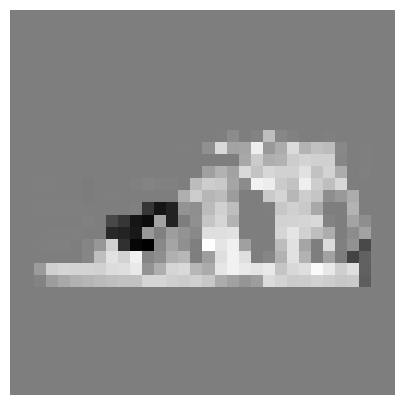

In [23]:
temp = mask_with_lime_cnn(img_ori, lbl)
draw_utils.show_original(temp)

In [24]:
# LIME Graph
from lime_graph import LimeGraphExplainer
# from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

lime_graph_explainer = LimeGraphExplainer()
# segmenter = SegmentationAlgorithm('slic',
#      n_segments=75,
#      multichannel=True,
#      slic_zero=True, start_label=0
# )

@torch.no_grad()
def batch_predict_graph(graph):
    output = model(graph.to(device))
    output = torch.nn.functional.softmax(output, dim=1)
    return output.detach().cpu().numpy()

def mask_with_lime_graph(img_ori, img_g, segments, lbl, num_samples=50, alpha=0.3):
    global m, mask
    img_temp = img_ori
    img_temp = img_temp.double().cpu().numpy()
    
    n_segments = np.max(segments) + 1
    node2map = {n: (segments == n) for n in range(n_segments)}

# explain_instance(np.transpose(img_temp, (1, 2, 0)), 
#                                          graph,
#                                          node2map,
#                                          batch_predict, # classification function
#                                          top_labels=5,
#                                          hide_color=0, 
#                                          num_samples=200,
# #                                          segmentation_fn=segmenter,
#                                          segments=segments,
#                                     )
    
    explanation = lime_graph_explainer.explain_instance(np.transpose(img_temp, (1, 2, 0)),
                                             img_g,
                                             node2map,
                                             batch_predict_graph, # classification function
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=num_samples,
#                                              segmentation_fn=segmenter,
                                             segments=segments,
                                             progress_bar=False,
                                        ) # number of images that will be sent to classification function

    temp, mask = explanation.get_image_and_mask(lbl,
                                                positive_only=True,
                                                num_features=int(n_segments ** 0.5),
                                                hide_rest=False)
    
    img_mask = mask * (1 - alpha) + (alpha)
#     plt.imshow(img_mask)
#     plt.axis('off')
#     plt.show()
    img_lime = img_mask * np.array(img_ori.squeeze())
#     show_original(img_lime)
#     plt.show()
    
    return img_lime

# temp = mask_with_lime_SPGIE(img_ori, img_g, segments, lbl, num_samples=2000)
# plt.imshow(np.transpose(temp, (1, 2, 0)))

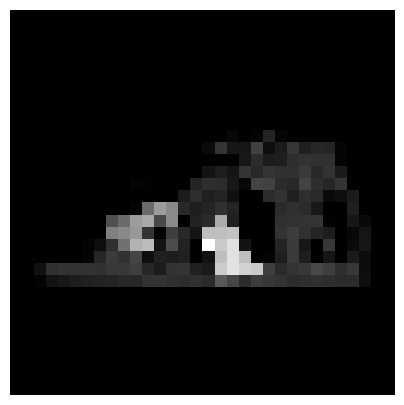

In [25]:
temp = mask_with_lime_graph(img_ori, img_sp, segments, lbl)
draw_utils.show_original(temp)

In [26]:
lbl_names[2], lbl_names[6]

('Pullover', 'Shirt')

In [27]:
lbl_names[1], lbl_names[3]

('Trouser', 'Dress')

idx 170
[(1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32)]
o tensor([0, 6, 2], device='cuda:1')
o tensor([0, 2, 6], device='cuda:1')
o tensor([0, 6, 2], device='cuda:1')
o tensor([0, 6, 2], device='cuda:1')
o tensor([0, 6, 2], device='cuda:1')
['84.4940%', '91.4441%', '97.1077%', '83.4610%', '88.1815%']
nnnnn 5


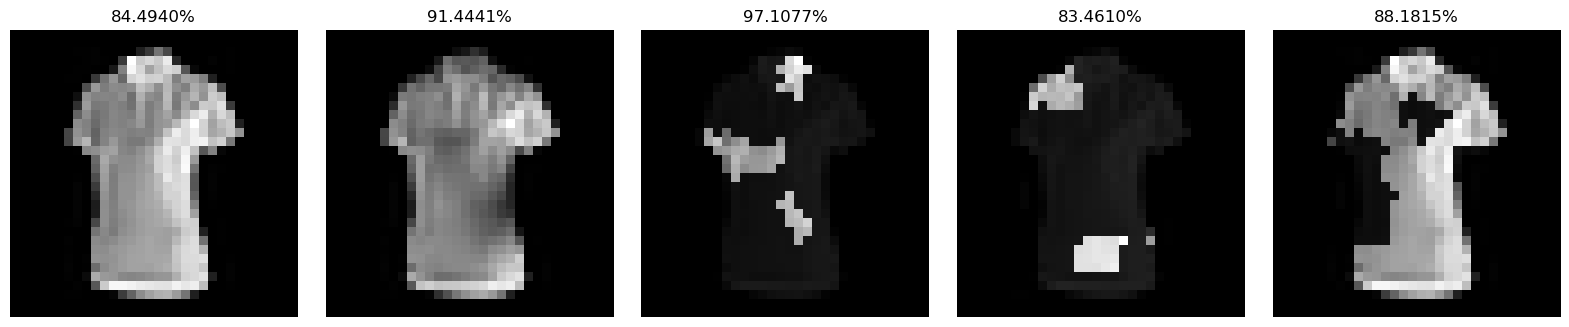

idx 171
[(1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32)]
o tensor([5, 8, 2], device='cuda:1')
o tensor([5, 8, 2], device='cuda:1')
o tensor([5, 8, 7], device='cuda:1')
o tensor([7, 5, 0], device='cuda:1')
o tensor([5, 8, 7], device='cuda:1')
['99.9983%', '99.9968%', '99.4013%', '22.9621%', '99.9971%']
nnnnn 5


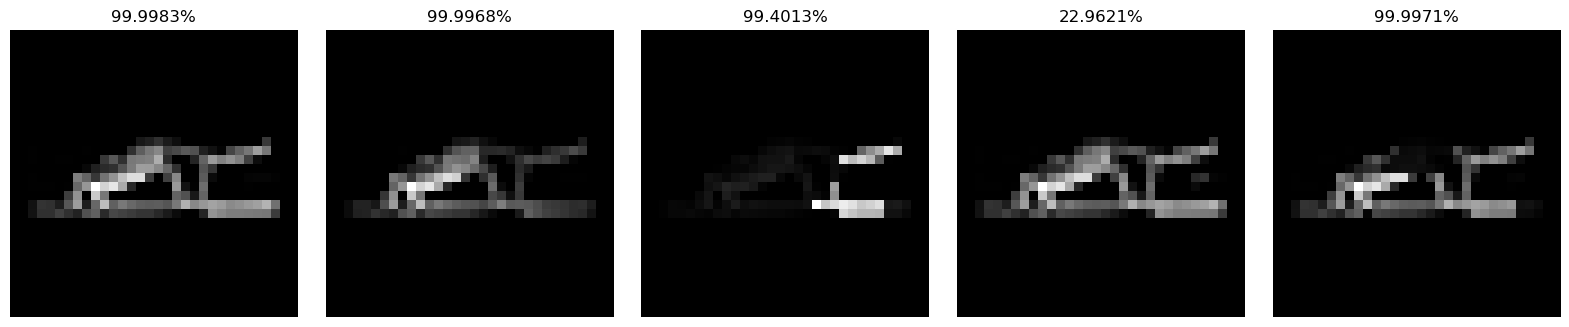

idx 172
[(1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32)]
o tensor([2, 8, 1], device='cuda:1')
o tensor([2, 6, 1], device='cuda:1')
o tensor([2, 0, 6], device='cuda:1')
o tensor([2, 6, 4], device='cuda:1')
o tensor([2, 6, 4], device='cuda:1')
['64.1872%', '79.1726%', '56.9984%', '66.1148%', '85.6037%']
nnnnn 5


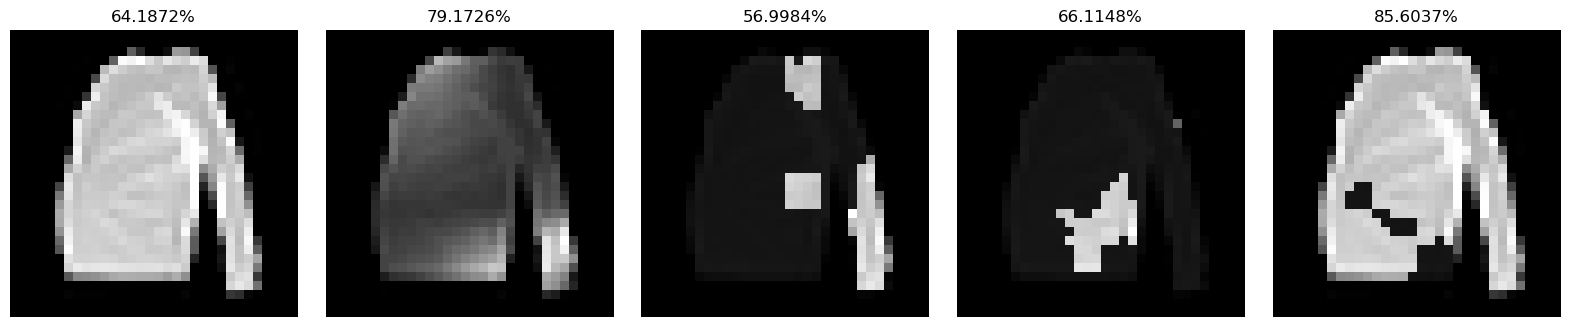

idx 173
[(1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32)]
o tensor([1, 6, 3], device='cuda:1')
o tensor([1, 3, 8], device='cuda:1')
o tensor([1, 8, 4], device='cuda:1')
o tensor([1, 3, 4], device='cuda:1')
o tensor([1, 3, 6], device='cuda:1')
['100.0000%', '100.0000%', '99.9996%', '99.8831%', '100.0000%']
nnnnn 5


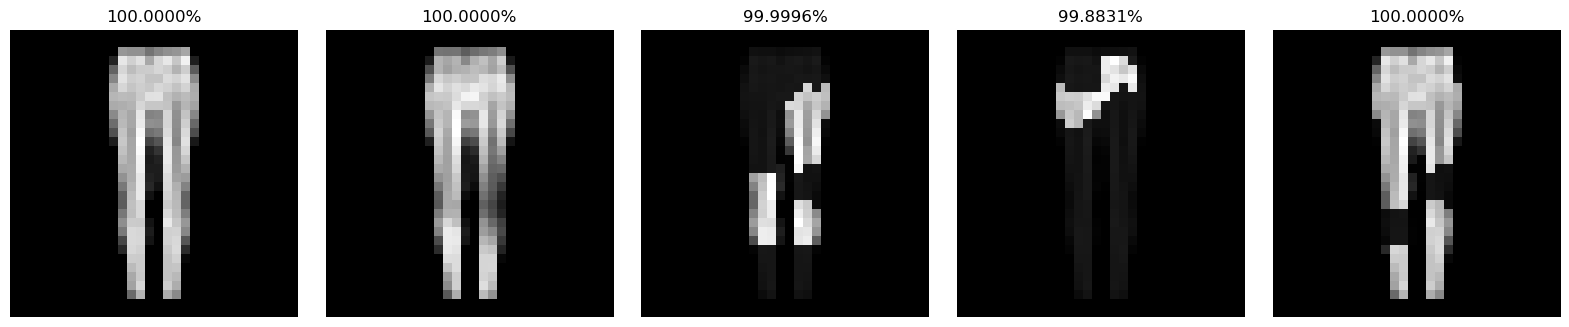

idx 174
[(1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32)]
o tensor([2, 6, 4], device='cuda:1')
o tensor([2, 8, 6], device='cuda:1')
o tensor([2, 0, 4], device='cuda:1')
o tensor([2, 0, 4], device='cuda:1')
o tensor([2, 6, 4], device='cuda:1')
['96.5602%', '97.8770%', '99.4106%', '99.1225%', '92.6905%']
nnnnn 5


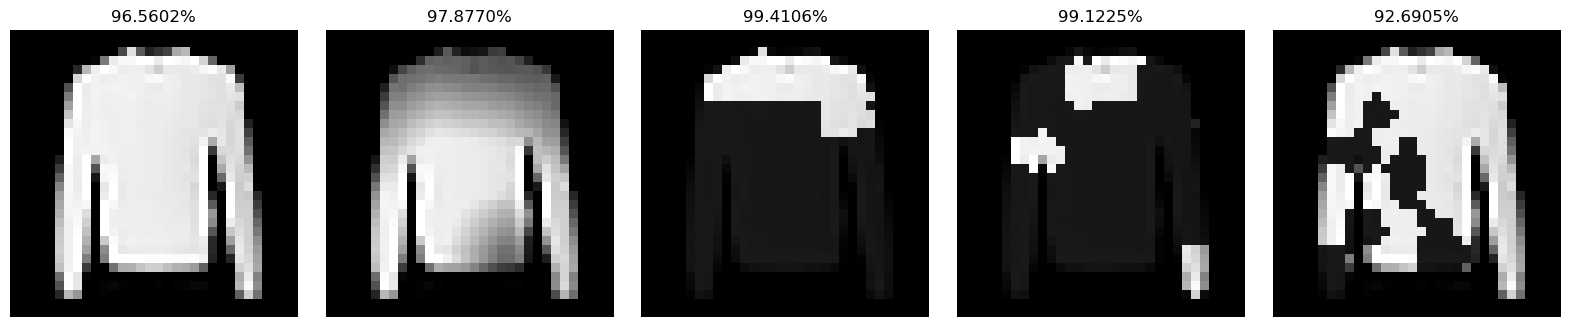

idx 175
[(1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32)]
o tensor([1, 6, 3], device='cuda:1')
o tensor([1, 3, 6], device='cuda:1')
o tensor([1, 3, 4], device='cuda:1')
o tensor([1, 3, 6], device='cuda:1')
o tensor([1, 6, 3], device='cuda:1')
['99.9998%', '99.9999%', '99.5527%', '88.9766%', '99.9997%']
nnnnn 5


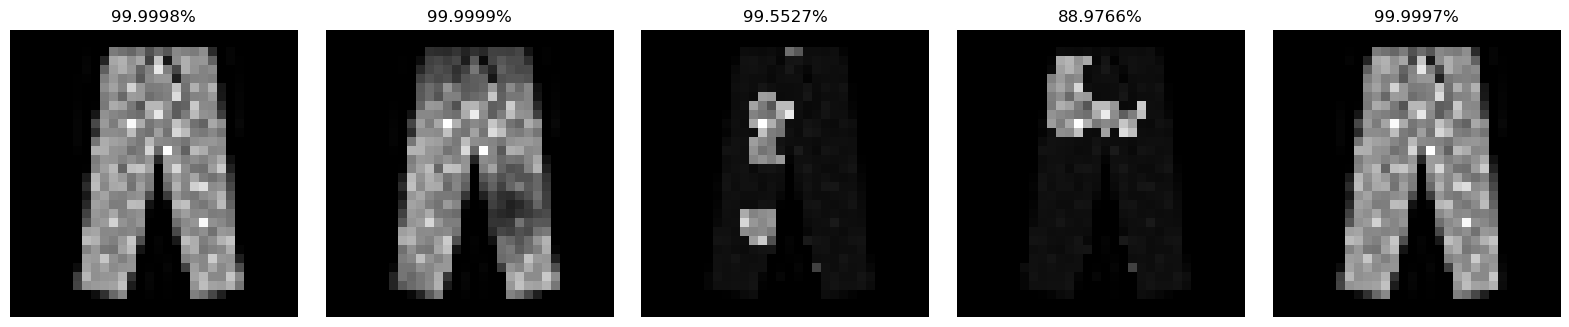

idx 176
[(1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32)]
o tensor([3, 2, 4], device='cuda:1')
o tensor([3, 2, 6], device='cuda:1')
o tensor([3, 0, 6], device='cuda:1')
o tensor([3, 4, 6], device='cuda:1')
o tensor([3, 2, 6], device='cuda:1')
['99.9631%', '99.9851%', '59.6017%', '87.2104%', '99.8628%']
nnnnn 5


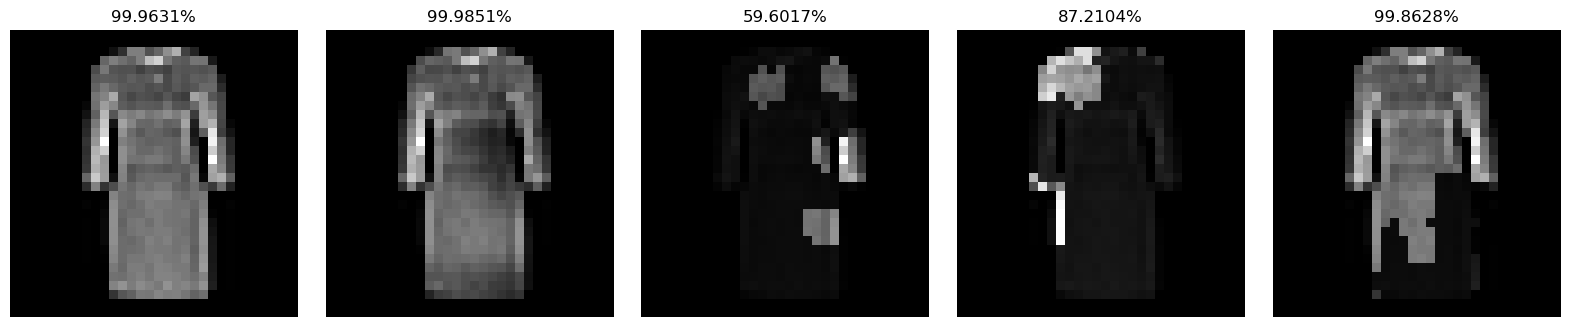

idx 177
[(1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32)]
o tensor([0, 6, 2], device='cuda:1')
o tensor([0, 2, 6], device='cuda:1')
o tensor([0, 6, 2], device='cuda:1')
o tensor([0, 6, 2], device='cuda:1')
o tensor([0, 2, 6], device='cuda:1')
['99.4134%', '97.2487%', '98.0733%', '98.9492%', '97.5795%']
nnnnn 5


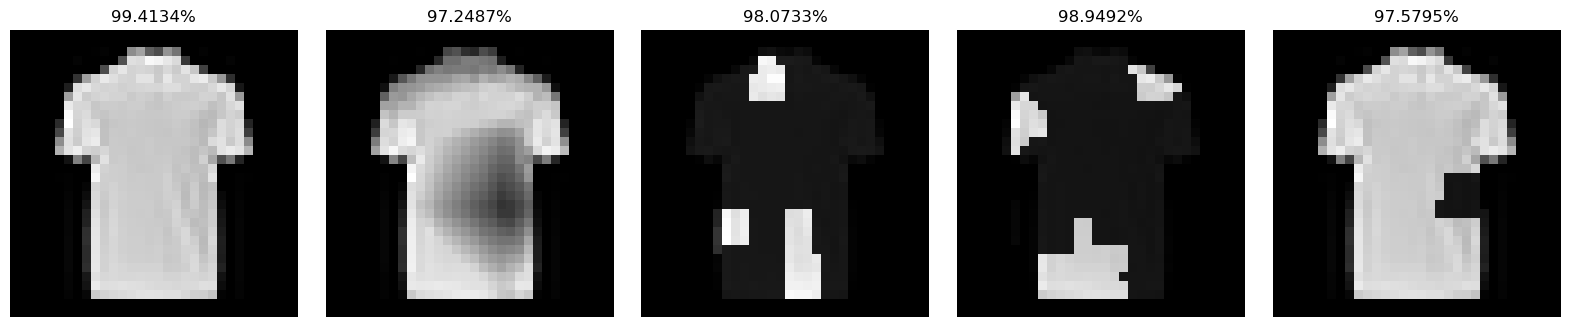

idx 178
[(1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32)]
o tensor([9, 5, 7], device='cuda:1')
o tensor([9, 5, 7], device='cuda:1')
o tensor([9, 5, 7], device='cuda:1')
o tensor([9, 5, 7], device='cuda:1')
o tensor([9, 5, 7], device='cuda:1')
['99.9990%', '99.8301%', '67.2906%', '58.4373%', '99.9987%']
nnnnn 5


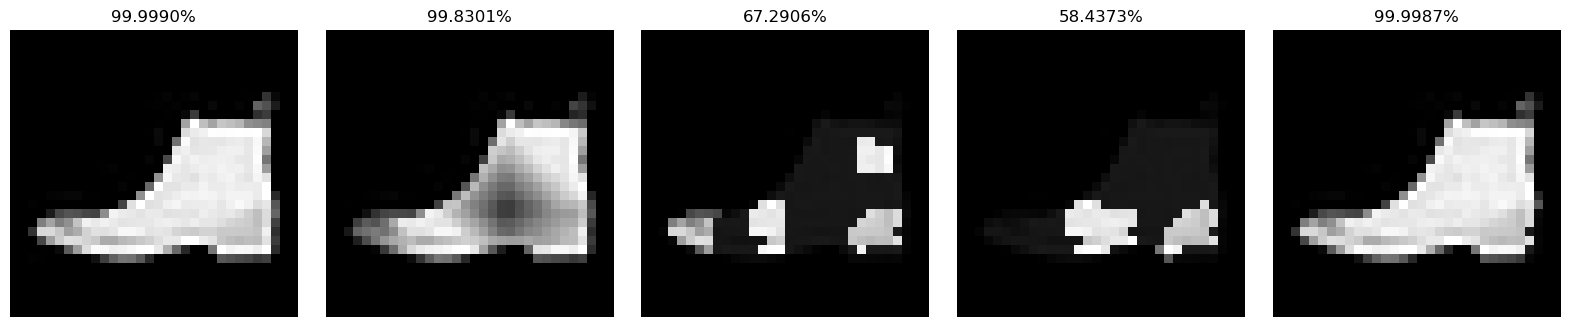

idx 179
[(1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32), (1, 32, 32)]
o tensor([1, 6, 3], device='cuda:1')
o tensor([1, 3, 6], device='cuda:1')
o tensor([1, 3, 2], device='cuda:1')
o tensor([1, 3, 6], device='cuda:1')
o tensor([1, 6, 3], device='cuda:1')
['100.0000%', '100.0000%', '99.9952%', '99.9703%', '100.0000%']
nnnnn 5


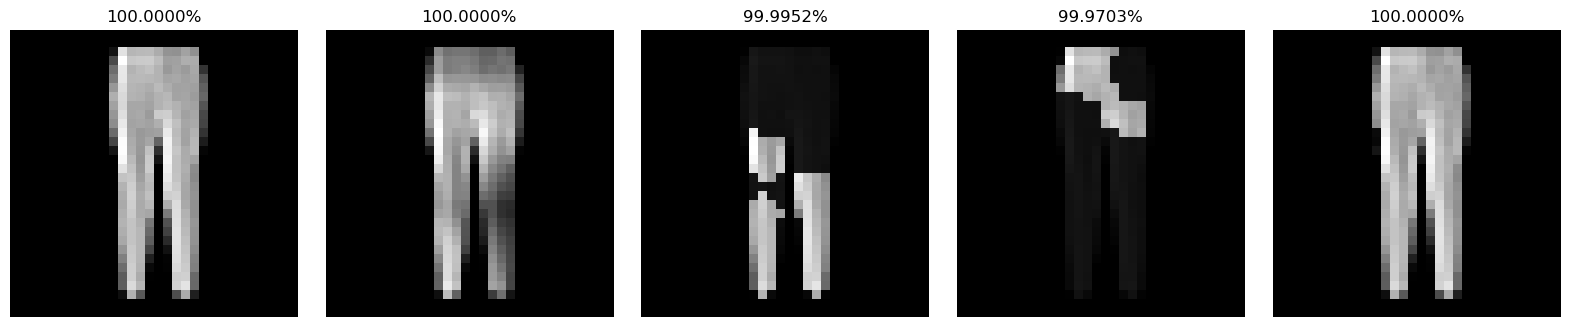

In [52]:
for img_idx in range(170, 180):
    try:
        print('idx', img_idx)
        img_ori, lbl = ori_dataset[img_idx]
        # img_ori, lbl = MNISTM(ORIGIN_DATA_DIR, mode='train')[img_idx]
        img_ori = rc(img_ori)
        img_sp, segments, node2map = make_segments_and_graph(
            torch.permute(img_ori, (1, 2, 0)), channel_axis=None,
            compactness=compactness,
        )

        # for one amge
        alpha = 0.1
        num_samples = 200

        img_spgie = mask_with_spgie(img_ori, img_sp, segments, lbl, alpha=alpha)
        img_cam = mask_with_cam(img_ori, lbl)
        img_lime_cnn = mask_with_lime_cnn(
            img_ori, lbl,
            num_samples=num_samples, alpha=alpha,
        )
        img_lime_graph = mask_with_lime_graph(
            img_ori, img_sp, segments, lbl,
            num_samples=num_samples, alpha=alpha,
        )

        img_masks = [
            img_ori.numpy(), img_cam,
            np.expand_dims(img_lime_cnn, 0), np.expand_dims(img_lime_graph, 0),
            np.expand_dims(img_spgie.mean(0), 0),
        ]
        print([im.shape for im in img_masks])
        # img_masks = [img_ori.numpy(), img_spgie, img_cam]
        img_input = torch.cat([torch.from_numpy(im).unsqueeze(0).float() for im in img_masks], dim=0)
        img_input = img_input.to(device2)
        # print(img_input.device)
        out = cnn_model(img_input)
        out = torch.softmax(out, dim=1)
        for o in out:
            print('o', torch.topk(o, 3).indices)
        #     print('o', torch.topk(o, 3).values)

        scores = out[:, lbl].detach().tolist()
        socres = ['{:.4f}%'.format(s * 100) for s in scores]
        print(socres)

    #         draw_utils.show_original(np.concatenate(img_masks, axis=2), width=20)

        print('nnnnn', len(img_masks))
        fig, axes = plt.subplots(1, len(img_masks), figsize=(20, 20), sharey=True)
        for i, ax in enumerate(axes):
            ax.imshow(np.transpose(img_masks[i], (1, 2, 0)), cmap='gray')
            ax.axis('off')
            ax.set_title(socres[i])

        plt.subplots_adjust(wspace=0.1)
        plt.show()
    except Exception as e:
        print(e)

## Profiler

In [29]:
from tqdm.auto import tqdm
import time

# == Profiler
# acc counter
# conf array
# explainer inference

# == loop
# timer
# img inference
# count acc

class Profiler:
    def __init__(self, num_samples, alpha):
        self.confs = []
        self.acc_count = 0
        self.running_time = 0.0
        
        self.num_samples = num_samples
        self.alpha = alpha
    
    def input_x(self, img_ori, lbl, img_g=None, segments=None):
        self.img_ori = img_ori
        self.img_g = img_g
        self.segments = segments
        self.lbl = lbl
    
    def mask_with_explainer(self, *args, **kwargs):
        raise NotImplementedError('Explainer method should be implemented.')
    
    def inference(self):
        t = time.time()
        res = self.mask_with_explainer()
        self.running_time += time.time() - t
        return res

class SPGIEProfiler(Profiler):
    @property
    def name(self):
        string = 'SPGIE'
        
        if self.smooth:
            string += ' sm({})'.format(self.smooth_thresholds)
        
        return string

    def __init__(self, num_samples, alpha, 
                 gx_threshold=1, counter_threshold=1,
                 smooth=False, smooth_thresholds=None,
                 *args, **kwargs,
    ):
        super().__init__(num_samples, alpha, *args, **kwargs)
        self.gx_threshold = gx_threshold
        self.counter_threshold = counter_threshold
        self.smooth = smooth
        self.smooth_thresholds = smooth_thresholds
        
    def mask_with_explainer(self):
        return mask_with_spgie(
            self.img_ori, self.img_g,
            self.segments, self.lbl,
            alpha=self.alpha,
            gx_threshold=self.gx_threshold, counter_threshold=self.counter_threshold,
            smooth=self.smooth, smooth_thresholds=self.smooth_thresholds,
        )
    
class GradCAMProfiler(Profiler):
    name = 'GradCAM'
    def mask_with_explainer(self):
        return mask_with_cam(
            self.img_ori, self.lbl,
            alpha=self.alpha,
        )

class LIMECNNProfiler(Profiler):
    name = 'LIME-CNN'
    def mask_with_explainer(self):
        return mask_with_lime_cnn(
            self.img_ori, self.lbl,
            num_samples=self.num_samples,
            alpha=self.alpha,
        )
    
class LIMEGraphProfiler(Profiler):
    name = 'LIME-Graph'
    def mask_with_explainer(self):
        return mask_with_lime_graph(
            self.img_ori, self.img_g,
            self.segments, self.lbl,
            num_samples=self.num_samples,
            alpha=self.alpha,
        )

In [30]:
import random

# max_size = len(test_ori_dset)
alpha = 0.2
num_samples = 50
# num_samples = 200
# num_samples = 500

# rand_size = 300
rand_size = 1000
# rand_size = 3000
# rand_size = len(test_ori_dset)

rand_idx = random.sample(range(len(ori_dataset)), rand_size)

In [31]:
profilers = [
    SPGIEProfiler(num_samples, alpha),
#     SPGIEProfiler(num_samples, alpha, gx_threshold=2),
#     SPGIEProfiler(num_samples, alpha, counter_threshold=2),
    
#     SPGIEProfiler(num_samples, alpha, counter_threshold=2, smooth=True, smooth_thresholds=[0.3, 0.7]),
    
    GradCAMProfiler(num_samples, alpha),
    LIMECNNProfiler(num_samples, alpha),
    LIMEGraphProfiler(num_samples, alpha),
]

# for s1 in range(1, 7): # from 0.1 ~ 0.6
#     for s2 in range(6, 9): # from 0.6 ~ 0.8
#         profilers.append(
#             SPGIEProfiler(num_samples, alpha, counter_threshold=2,
#                           smooth=True, smooth_thresholds=[s1 / 10, s2 / 10]
#             ),
#         )

print(profilers)

t_cnn = 0.0
t_make_graph = 0.0

cnn_count = 0
confs_cnn = []


loader = tqdm(rand_idx, total=rand_size)
for idx in loader:
    t = time.time()
    img_ori, lbl = ori_dataset[idx]
    img_ori = rc(img_ori)
    img_g, segments, node2map = make_segments_and_graph(
        torch.permute(img_ori, (1, 2, 0)), channel_axis=None,
        compactness=compactness,
    )
    t_make_graph = time.time() - t
#     segments = slic(np.transpose(img_ori, (1, 2, 0)), n_segments=75,
#                      multichannel=True,
#                      slic_zero=True, start_label=0,
#     )

    img_masks = [img_ori.numpy()]
    for p in profilers:
        p.input_x(img_ori, lbl, img_g, segments)

        try:
            temp = p.inference()
            if temp.shape[0] == 3:
                temp = temp.mean(0)
            if temp.ndim == 2:
                temp = np.expand_dims(temp, 0)
            img_masks.append(temp)
        except:
            pass
        
    img_input = torch.cat([torch.from_numpy(im).unsqueeze(0) for im in img_masks], dim=0)
    img_input = img_input.to(device2).float()
    t = time.time()
    out = cnn_model(img_input)
    t_cnn += time.time() - t
    out = torch.softmax(out, dim=1)
    
    confs = out[:, lbl].detach().tolist()
    confs_cnn.append(confs[0])
    if out[0, :].argmax(dim=0).item() == lbl:
        cnn_count += 1

    for i, p in enumerate(profilers):
        if i + 1 >= out.shape[0]:
            p.confs.append(None)
            continue
        if out[i + 1, :].argmax(dim=0).item() == lbl:
            p.acc_count += 1
        
        p.confs.append(confs[i + 1])

[<__main__.SPGIEProfiler object at 0x7efc7a4cc700>, <__main__.GradCAMProfiler object at 0x7efc7a4cdab0>, <__main__.LIMECNNProfiler object at 0x7efc7a4cd270>, <__main__.LIMEGraphProfiler object at 0x7efc7a4ccfd0>]


100%|██████████| 1000/1000 [06:37<00:00,  2.51it/s]


## Report

In [32]:
print('n_samples', num_samples, 'rand_size', rand_size)
for p in profilers:
    print(p.name, p.running_time)

print('CNN inference', t_cnn)

n_samples 50 rand_size 1000
SPGIE 19.920457363128662
GradCAM 15.732216835021973
LIME-CNN 78.25025057792664
LIME-Graph 263.58695220947266
CNN inference 5.541868209838867


In [33]:
print('cnn\tacc:', cnn_count / len(confs_cnn))

for p in profilers:
    print(p.name, p.acc_count / len([c for c in p.confs if c != None]))

cnn	acc: 0.941
SPGIE 0.906
GradCAM 0.859
LIME-CNN 0.822
LIME-Graph 0.8343434343434344


In [34]:
def evaluation_count(confs_cnn, p):
    print(p.name)
    
    confs = np.array(p.confs)
    mask = confs != None
    confs = confs[mask]
    confs_cnn2 = np.array(confs_cnn)[mask]
    
    conf_diff = np.mean(confs - confs_cnn2)
    avg_increase = np.mean(confs > confs_cnn2) * 100
    drop_masked = confs < confs_cnn2
    avg_drop = np.mean(np.abs(confs[drop_masked] - confs_cnn2[drop_masked])) * 100
    
    print('Diff: {:.4f}\tTime: {:.2f}s\tAvgInc: {:5.2f}%\tAvgDrop: {:5.2f}%'.format(
        conf_diff, p.running_time, avg_increase, avg_drop,
    ))
    
for p in profilers:
    evaluation_count(confs_cnn, p)

SPGIE
Diff: -0.0332	Time: 19.92s	AvgInc: 18.90%	AvgDrop:  6.98%
GradCAM
Diff: -0.0719	Time: 15.73s	AvgInc: 19.30%	AvgDrop: 13.27%
LIME-CNN
Diff: -0.1343	Time: 78.25s	AvgInc: 12.50%	AvgDrop: 17.87%
LIME-Graph
Diff: -0.1293	Time: 263.59s	AvgInc: 11.92%	AvgDrop: 16.87%


In [40]:
metrics = '''SPGIE
Diff: -0.0332	Time: 19.92s	AvgInc: 18.90%	AvgDrop:  6.98%
GradCAM
Diff: -0.0719	Time: 15.73s	AvgInc: 19.30%	AvgDrop: 13.27%
LIME-CNN
Diff: -0.1343	Time: 78.25s	AvgInc: 12.50%	AvgDrop: 17.87%
LIME-Graph
Diff: -0.1293	Time: 263.59s	AvgInc: 11.92%	AvgDrop: 16.87%'''

In [41]:
header = 'Method,Diff,Time,AvgInc,AvgDrop\n'
ms = metrics.replace('\nDiff: ', ',')
ms = ms.replace('\tTime: ', ',').replace('\tAvgInc: ', ',').replace('\tAvgDrop: ', ',')
# ms = ms.split('\n')
print(header + ms)

with open('faithfull_fashion_mnist.csv', 'w', encoding='utf-8') as f:
    f.write(header + ms)

Method,Diff,Time,AvgInc,AvgDrop
SPGIE,-0.0332,19.92s,18.90%, 6.98%
GradCAM,-0.0719,15.73s,19.30%,13.27%
LIME-CNN,-0.1343,78.25s,12.50%,17.87%
LIME-Graph,-0.1293,263.59s,11.92%,16.87%


In [37]:
smooth_m = metrics.split('\nSPGIE')[1:]
smooth_m = [
    {
        'l2': float(m[5:8]),
        'l1': float(m[10:13]),
        'increase': float(m[50:56]),
        'drop': float(m[66:-1]),
    }
    for m in smooth_m
]

In [38]:
fsize1 = 16
fsize2 = 8

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6,) and arg 1 with shape (0,).

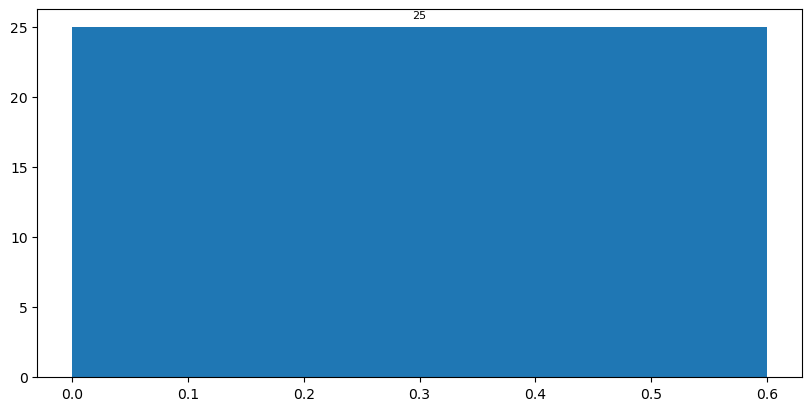

In [39]:
l2_params = [f'l2 = {i / 10}' for i in range(1, 7)]
original_increase = 25.00
original_drop = 2.62

smooth_increase = {
    f'l1 = {(i + 6) / 10}' : [m['increase'] + 3.8 for m in smooth_m[i::3]]
    for i in range(3)
}
smooth_drop = {
    f'l1 = {(i + 6) / 10}' : [m['drop'] for m in smooth_m[i::3]]
    for i in range(3)
}


x = np.arange(len(l2_params) + 1)  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 4))

orig = ax.bar(width, original_increase, width*2, label='Original')
ax.bar_label(orig, padding=5, fontsize=fsize2)

for attribute, measurement in smooth_increase.items():
    offset = width * multiplier
    rects = ax.bar(x[1:] + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=5, fontsize=fsize2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Increase (%)', fontsize=fsize1)
ax.set_title('Average Increase by Distance regularization', fontsize=fsize1)
ax.set_xticks(x + width, ['Original'] + l2_params, fontsize=fsize2 + 2)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 30)

plt.savefig('distance_regularization_inc.svg')
# plt.show()

In [ ]:
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 4))

orig = ax.bar(width, original_drop, width*2, label='Original')
ax.bar_label(orig, padding=5, fontsize=fsize2)

for attribute, measurement in smooth_drop.items():
    offset = width * multiplier
    rects = ax.bar(x[1:] + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=5, fontsize=fsize2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Drop (%)', fontsize=fsize1)
ax.set_title('Average Drop by Distance regularization', fontsize=fsize1)
ax.set_xticks(x + width, ['Original'] + l2_params, fontsize=fsize2 + 2)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 15)

plt.savefig('distance_regularization_drop.svg')
# plt.show()